In [16]:
import torch
from receptive_fields.models.retinal import RetinalModel
from torchinfo import summary
from receptive_fields.util.activation_visualization import single_effective_receptive_field, get_input_output_shape
from matplotlib import pyplot as plt
from receptive_fields.util.experiment_setup import load_dataset, load_model
from receptive_fields.util.training import train, num_correct

from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
import os

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [26]:
img_size = (160,120)#(143,107)#(179,143)#
# retinal_base_model = RetinalModel(img_size=img_size, num_classes=10, n_base_channels=16, n_lgn_channels=32, ceil_mode=True, l1_kernel_size=3, pool=[True, True, True], spd=[1,1,1], lgn_kernel_size=3, v1_kernel_size=4, rgc_kernel_size=3, fc_act=True)
# mod3 = RetinalModel(img_size=img_size, num_classes=10, n_base_channels=16, n_lgn_channels=32, ceil_mode=True, l1_kernel_size=7, pool=[False, False, True], spd=[2,2,1], lgn_kernel_size=7, v1_kernel_size=7, rgc_kernel_size=7, fc_act=True)
# model = mod3
model = load_model("models/incnet/stride_3_2_2_1_ks_dec")

in_channels = model.in_channels
img_size = model.img_size

train_data = load_dataset(grayscale= in_channels==1, img_size=model.img_size)
train_loader = DataLoader(train_data, batch_size=512, shuffle=False)
model.to(device)
summary(model, (1,3,*img_size))

Files already downloaded and verified


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 51, 38]           7,808
├─Sequential: 1-8                        --                        (recursive)
│    └─ELU: 2-1                          [1, 32, 51, 38]           --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Conv2d: 2-2                       [1, 32, 23, 16]           50,208
├─Sequential: 1-8                        --                        (recursive)
│    └─ELU: 2-3                          [1, 32, 23, 16]           --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Conv2d: 2-4                       [1, 32, 10, 6]            25,632
├─Sequential: 1-8                        --                        (recursive)
│    └─ELU: 2-5                          [1, 32, 10, 6]            --
├─ModuleList: 1-7            

In [27]:
model

SimpleCNN(
  (_activation_func): ELU(alpha=1.0, inplace=True)
  (space_to_depth): SpaceToDepth()
  (conv1): Conv2d(3, 32, kernel_size=(9, 9), stride=(3, 3))
  (softmax): Softmax(dim=-1)
  (extra_conv_layers): ModuleList(
    (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(2, 2))
    (1): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [28]:
model=model.to(device)

In [29]:
(inputs, labels) = next(iter(train_loader))
inputs = inputs.to(device)
labels = labels.to(device)

In [30]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005, weight_decay=1e-6)
with torch.autograd.profiler.profile(use_cuda=True, record_shapes=True) as prof:
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    # Training loop
    model.train()  # Set the model to training mode
    running_loss = 0.0

    epoch_correct = 0
    pbar = tqdm(range(100))
    for i in pbar:
        # optimizer.zero_grad()  # Zero the parameter gradients
        for param in model.parameters():
            param.grad = None
        # Forward pass
        outputs = model(inputs)
        batch_correct =  num_correct(outputs, labels)
        epoch_correct += batch_correct
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        pbar.set_postfix({'Loss': loss.item(), 'Acc.:': batch_correct/len(labels)})

STAGE:2024-05-23 11:22:48 33767:33767 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
100%|██████████| 100/100 [00:03<00:00, 25.60it/s, Loss=4.39e+3, Acc.:=0.105]
STAGE:2024-05-23 11:22:52 33767:33767 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-23 11:22:52 33767:33767 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [31]:
key_avgs = prof.key_averages(group_by_input_shape=True)

In [32]:
print(key_avgs.table(sort_by="self_cuda_time_total", row_limit=50, max_shapes_column_width=100))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls                                                                                Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------------------------------------------------------------  
                             aten::convolution_backward         0.61%      21.310ms         1.27%      44.609ms     446.090us    

In [33]:
aaa

NameError: name 'aaa' is not defined

In [ ]:
avgs = prof.key_averages()
print(avgs.table(sort_by="self_cuda_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             aten::convolution_backward         1.43%     102.897ms         2.37%     170.564ms     426.410us        2.227s        30.21%        2.498s       6.245ms           400  
                              aten::avg_pool2d_backward         0.46%      32.970ms         0.51%      36.898ms     184.490us        1.722s        23.35%        1.722s       8.608ms           200  
         

In [ ]:
avgs[index_conv].self_cuda_time_total

1505

In [ ]:
base_path = "../performance/{}_{}_resnet18/".format(*img_size)
if not os.path.exists(base_path):
    os.mkdir(base_path)

In [ ]:
prof.export_chrome_trace(base_path + "trace.json")

In [ ]:
with open(base_path+"key_averages.csv", "w+t") as f:
    f.write(key_avgs.table(sort_by="self_cuda_time_total", row_limit=50, max_shapes_column_width=100))

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

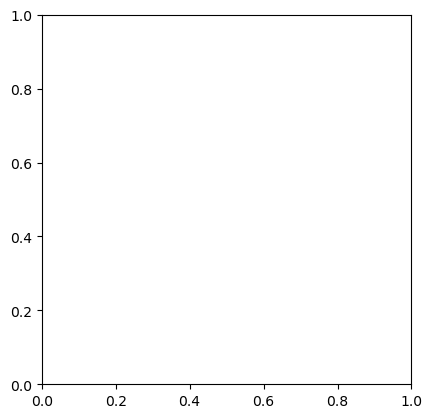

In [ ]:
plt.imshow(model.retina[0].weight[2,0].cpu())

In [ ]:
combined_model=trained_model.get_sequential()

NameError: name 'trained_model' is not defined

In [ ]:
combined_model[2]=model.get_sequential()[2]
combined_model[5]=model.get_sequential()[5]
combined_model[10]=model.get_sequential()[10]
combined_model[12]=model.get_sequential()[12]

In [ ]:
combined_model=model

torch.Size([1, 10])
torch.Size([1, 10])
tensor(0.) tensor(0.)


/gpfs01/berens/user/fseel/miniconda3/envs/receptive-fields/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


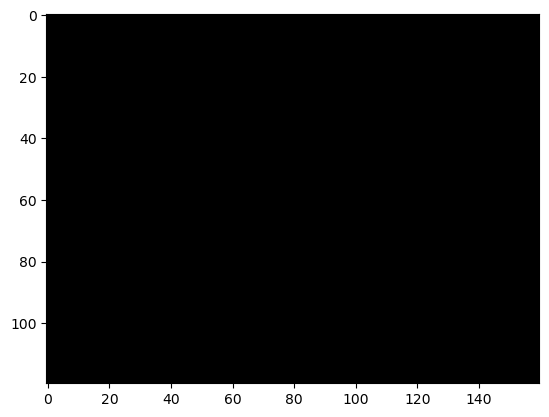

In [ ]:
from util.activation_visualization import sum_collapse_output, rescaleZeroOne
cur_model = combined_model
cur_img_size = img_size#(16,12)#
out = cur_model(torch.rand((1,3,*cur_img_size)).to(device))
print(out.shape)
out = torch.full_like(sum_collapse_output(out), 0.2)
print(out.shape)
eff_rf = single_effective_receptive_field(cur_model, output_signal=out.to(device), input_size=(3,*cur_img_size), n_batch=1, device=device)
print(eff_rf.min(), eff_rf.max())
plt.imshow(torch.swapdims(rescaleZeroOne(eff_rf), 0,2))
# plt.imshow((eff_rf!=0).numpy()[0])
plt.show()

In [ ]:
cur_model

RetinalModel(
  (retina): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): AvgPool2d(kernel_size=3, stride=3, padding=0)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=3, stride=3, padding=0)
    (6): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (9): ELU(alpha=1.0)
    (10): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=True)
    (11): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)